In [1]:
import pandas as pd
import numpy as np
import transformers
from transformers import BertForSequenceClassification
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt


/home/dck5549/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mrda = pd.read_csv("mrda/MRDA_data.csv")


#assign values to labels
mrda.loc[mrda['Basic'] == 'S', 'Basic'] = 0
mrda.loc[mrda['Basic'] == 'F', 'Basic'] = 1
mrda.loc[mrda['Basic'] == 'B', 'Basic'] = 2
mrda.loc[mrda['Basic'] == 'D', 'Basic'] = 3
mrda.loc[mrda['Basic'] == 'Q', 'Basic'] = 4

content = mrda['utterance']
labels = mrda['Basic']


In [4]:
content

0                                                     okay.
1                                                     so um
2         i was going to try to get out of here like in ...
3                                                        um
4                because i really appreciate people coming.
                                ...                        
108197                                               great.
108198                                               great.
108199    do we need do i need to turn something off her...
108200                               now these we turn off.
108201                                               right?
Name: utterance, Length: 108202, dtype: object

In [3]:
#split data into train and test

split = int(len(content) * 0.8)

train_data = content[:split]
train_labels = labels[:split]

test_data = content[split:]
test_labels = labels[split:]

print(train_data.size, test_data.size)
print(train_labels.size, test_labels.size)


86561 21641
86561 21641


In [4]:
'''prepare dataset, for making classifications the model will be given the statement before the statement being predicted for additional context. For example, for the following sequence:

Everything is ON. I have everything.
I have nothing. Wait, just a second. Uno momento por favor.
Nothing [UI]

To make a prediction for the first statement, the input to the model will be:

"Everything is ON. I have everything."

For the second:

"Everything is ON. I have everything. I have nothing. Wait, just a second. Uno momento por favor"

And for the third:

"I have nothing. Wait, just a second. Uno momento por favor. Nothing [UI]"

'''
class BertDataset(Dataset):
    def __init__(self, data, labels, tokenizer, max_length):
        super(BertDataset, self).__init__()
        self.train_csv=data.to_numpy()
        self.tokenizer=tokenizer
        self.target=labels.to_numpy()
        self.max_length=max_length
        
    def __len__(self):
        return len(self.train_csv)
    
    def __getitem__(self, index):
        
        if index > 0:
            text1 = self.train_csv[index - 1]
            text2 = self.train_csv[index]
            inp = "[CLS] " + text1 + "[SEP]" + text2
        else:
            text = self.train_csv[index]
            inp = "[CLS] " + text + "[SEP]"

        inputs = self.tokenizer.encode_plus(
            inp,
            add_special_tokens=False,
            return_attention_mask=True,
            max_length=self.max_length,
            truncation=True,
            padding="max_length"
        )

        ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        mask = inputs["attention_mask"]

        label = np.zeros(5)
        label[self.target[index]] = 1

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': torch.tensor(label, dtype=torch.long)
            }
    

In [5]:
# Metrics used to train model
# Taken from https://towardsdatascience.com/fine-tuning-bert-for-text-classification-54e7df642894
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [6]:
batch_size = 16

tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")

train_dataset = BertDataset(train_data, train_labels, tokenizer, max_length=256)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BertDataset(test_data, test_labels, tokenizer, max_length=256)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [7]:
for i in train_loader:
    print(i['target'])
    break

tensor([[1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0]])


In [27]:
# Load the BertForSequenceClassification model, which will train both the embedding space and also the classifier layer on top
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 5,
    output_attentions = False,
    output_hidden_states = False,
)

# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08
                              )

criterion = torch.nn.CrossEntropyLoss()

# Train on the gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [28]:
for i in train_loader:
    batch = i
    break

b_input_ids = batch['ids']
b_input_mask = batch['mask']
b_token_type_ids = batch['token_type_ids']
b_labels = batch['target']


print(b_input_ids.size())
print(b_input_mask.size())
print(b_token_type_ids.size())
print(b_labels.size())

model.eval()
with torch.no_grad():

    train_output = model(b_input_ids, 
                        token_type_ids = b_token_type_ids, 
                        attention_mask = b_input_mask)
    
logits = train_output.logits

max_indices = torch.argmax(logits, dim=1)

# Create a one-hot tensor
one_hot = torch.zeros(logits.size())
one_hot.scatter_(1, max_indices.view(-1, 1), 1)



torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16, 5])


tensor([[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]])

In [8]:
def logits_to_preds(logits):
    max_indices = torch.argmax(logits, dim=1)

    # Create a one-hot tensor
    one_hot = torch.zeros(logits.size())
    one_hot.scatter_(1, max_indices.view(-1, 1), 1)

    return one_hot

In [30]:
epochs = 3
for _ in range(epochs):
    
    # ========== Training ==========
    
    # =============== TRAIN ================
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_loader):

        b_input_ids = batch['ids']
        b_input_mask = batch['mask']
        b_token_type_ids = batch['token_type_ids']
        b_labels = batch['target']

        optimizer.zero_grad()

        # Forward pass
        train_output = model(b_input_ids, 
                            token_type_ids = b_token_type_ids, 
                            attention_mask = b_input_mask)

        # Backward pass
        loss = criterion(train_output.logits.to(torch.float), b_labels.to(torch.float))
        loss.backward()
        optimizer.step()

        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    


In [9]:
#This is for evaluation of already trained model, if retraining get rid of this block

model = BertForSequenceClassification.from_pretrained("../models/mrda_backwards_context.model/")

In [10]:
# ============== VALIDATE =================

# Set model to evaluation mode
model.eval()

preds = []
true = []

for batch in test_loader:

    b_input_ids = batch['ids']
    b_input_mask = batch['mask']
    b_token_type_ids = batch['token_type_ids']
    b_labels = batch['target']

    with torch.no_grad():
        # Forward pass
        eval_output = model(b_input_ids, 
                            token_type_ids = None,
                            attention_mask = b_input_mask)
    
    logits = logits_to_preds(eval_output.logits.to(torch.float))
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to(torch.float).cpu().numpy()

    preds.append(logits)
    true.append(label_ids)

    

In [11]:
unpacked_preds = []
unpacked_true = []

m = {
    0 : 'statement',
    1 : 'disruption',
    2 : 'backchannel',
    3 : 'follow-me',
    4 : 'question'
}

for batch in preds:
    for p in batch:
        i = np.argmax(p)
        unpacked_preds.append(m[i])

for batch in true:
    for p in batch:
        i = np.argmax(p)
        unpacked_true.append(m[i])

unpacked_true

['backchannel',
 'follow-me',
 'statement',
 'statement',
 'statement',
 'backchannel',
 'statement',
 'statement',
 'statement',
 'follow-me',
 'backchannel',
 'statement',
 'question',
 'statement',
 'backchannel',
 'statement',
 'statement',
 'statement',
 'backchannel',
 'statement',
 'backchannel',
 'disruption',
 'statement',
 'follow-me',
 'backchannel',
 'statement',
 'statement',
 'statement',
 'statement',
 'statement',
 'statement',
 'backchannel',
 'statement',
 'statement',
 'statement',
 'backchannel',
 'follow-me',
 'statement',
 'follow-me',
 'statement',
 'statement',
 'statement',
 'statement',
 'backchannel',
 'statement',
 'statement',
 'statement',
 'statement',
 'statement',
 'statement',
 'follow-me',
 'statement',
 'statement',
 'backchannel',
 'disruption',
 'statement',
 'follow-me',
 'statement',
 'statement',
 'backchannel',
 'follow-me',
 'statement',
 'backchannel',
 'statement',
 'follow-me',
 'statement',
 'follow-me',
 'backchannel',
 'question',
 'ques

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


labels = ["statement", "disruption", "backchannel", "follow-me", "question"]

# Example lists of true labels and model predictions
true_labels = pd.DataFrame(unpacked_true)[0]
model_predictions = pd.DataFrame(unpacked_preds)[0]

# Convert string labels to numerical labels if needed (depends on the specific metrics you want to compute)
# For example, if using precision, recall, and F1-score, numerical labels are required
label_mapping = {label: idx for idx, label in enumerate(true_labels.unique())}
true_labels_numeric = true_labels.map(label_mapping)
model_predictions_numeric = model_predictions.map(label_mapping)

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, model_predictions)
precision = precision_score(true_labels_numeric, model_predictions_numeric, average='weighted')
recall = recall_score(true_labels_numeric, model_predictions_numeric, average='weighted')
f1 = f1_score(true_labels_numeric, model_predictions_numeric, average='weighted')

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Display detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, model_predictions))

# Compute and display confusion matrix with columns
conf_matrix = confusion_matrix(true_labels, model_predictions, labels=true_labels.unique())
conf_matrix_df = pd.DataFrame(conf_matrix, index=true_labels.unique(), columns=true_labels.unique())
print("\nConfusion Matrix:")
print(conf_matrix_df)

# Calculate accuracy for each class
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_accuracies_df = pd.DataFrame({'Accuracy': class_accuracies}, index=true_labels.unique())
print("\nAccuracy for Each Class:")
print(class_accuracies_df)

Accuracy: 0.8722
Precision: 0.8986
Recall: 0.8722
F1-score: 0.8781

Classification Report:
              precision    recall  f1-score   support

 backchannel       0.62      0.94      0.75      3316
  disruption       0.83      0.78      0.81      1857
   follow-me       0.97      0.81      0.88      2627
    question       0.92      1.00      0.96      1174
   statement       0.96      0.87      0.91     12667

    accuracy                           0.87     21641
   macro avg       0.86      0.88      0.86     21641
weighted avg       0.90      0.87      0.88     21641


Confusion Matrix:
             backchannel  follow-me  statement  question  disruption
backchannel         3108          1        183         0          24
follow-me            110       2136        115         9         257
statement           1553          2      11007        97           8
question               0          0          0      1173           1
disruption           232         68        105         0

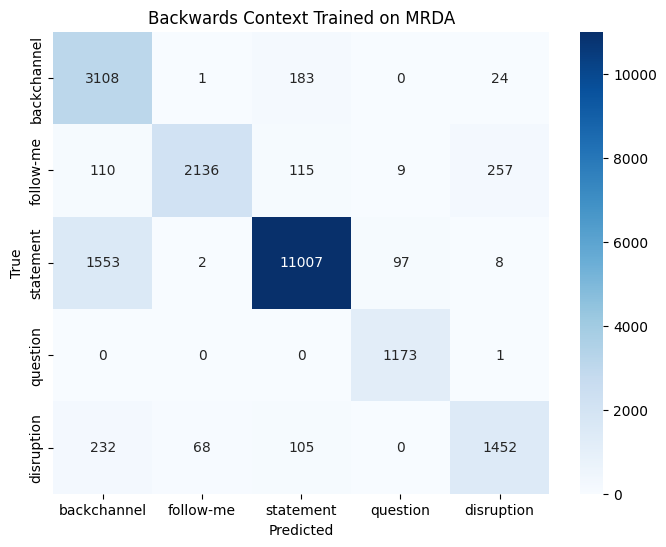

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns






# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=true_labels.unique(), yticklabels=true_labels.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Backwards Context Trained on MRDA')
plt.show()

In [10]:
total_correct = 0
total = 0

pred_hist = np.array([0,0,0,0,0])
true_hist = np.array([0,0,0,0,0])

#keys correspond to utterance types
type_counts = {
    0 : 0,
    1 : 0,
    2 : 0,
    3 : 0,
    4 : 0
}

for i, pred in enumerate(preds):

    #update histograms
    pred_hist = pred_hist + np.sum(pred, axis=0)
    true_hist = true_hist + np.sum(true[i], axis=0)

    #total example count
    total += len(pred)

    #argmax should be same if prediction is correct
    t = np.argmax(true[i], axis=1)
    pred = np.argmax(pred, axis=1)

    #count number of correct predictions
    num_correct = sum(t == pred)
    total_correct += num_correct

    #this is used to find the accuracy of each type of utterance
    #if the model's prediciton is correct, leave the current value, which
    #will be the index corresponding to the type of utterance, otherwise make it 9, (9 is trivial)

    type_correct = np.where(t == pred, pred, 9)
    vals, counts = np.unique(type_correct, return_counts=True)

    for i,val in enumerate(vals):
        if val in type_counts:
            type_counts[val] += counts[i]






print(total_correct/total)



0.8722332609398826


In [11]:
np.array(list(type_counts.values())) / true_hist


array([0.86895082, 0.7819063 , 0.93727382, 0.81309478, 0.99914821])

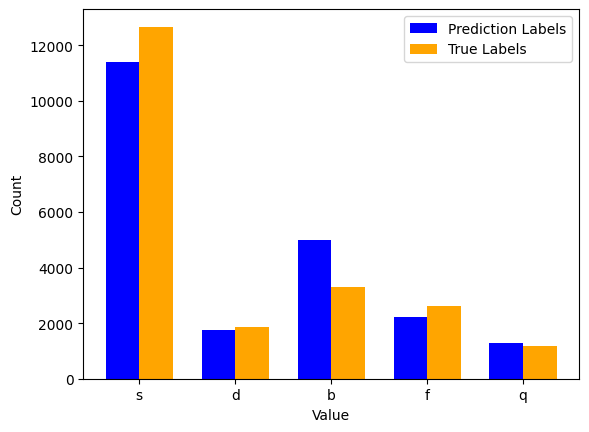

In [12]:

plot_labels = ['s', 'd', 'b', 'f', 'q']

x = np.arange(5)
bar_width = 0.35

plt.bar(x - bar_width/2, pred_hist, bar_width, label='Prediction Labels', color='blue')

# Create the second set of bars next to the first set
plt.bar(x + bar_width/2, true_hist, bar_width, label='True Labels', color='orange')

plt.xlabel('Value')
plt.ylabel('Count')
plt.xticks(x, plot_labels)
plt.legend()

plt.show()

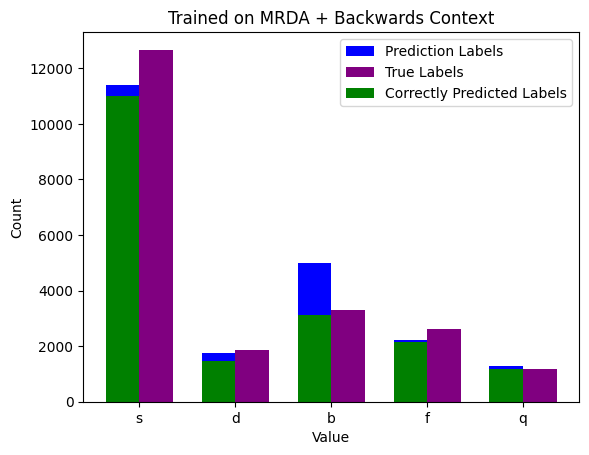

In [14]:
correct = list(type_counts.values())

plot_labels = ['s', 'd', 'b', 'f', 'q']

x = np.arange(5)
bar_width = 0.35

plt.bar(x - bar_width/2, pred_hist, bar_width, label='Prediction Labels', color='blue')

# Create the second set of bars next to the first set
plt.bar(x + bar_width/2, true_hist, bar_width, label='True Labels', color='purple')

plt.bar(x - bar_width/2, correct, bar_width, label='Correctly Predicted Labels', color='green', alpha=1)

plt.xlabel('Value')
plt.ylabel('Count')
plt.xticks(x, plot_labels)
plt.legend()

plt.title('Trained on MRDA + Backwards Context')

plt.show()

In [ ]:
model.save_pretrained("../models/mrda_backwards_context.model")